In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

proj_root = os.path.dirname(os.path.abspath("."))
# print(proj_root)
sys.path.append(proj_root)

import time
import datetime
import torch
import random
import numpy as np
import os
from pathlib import Path
import argparse

import torch.optim as optim
import torch.nn.functional as F

import gym 

import yaml

from minatar_dqn.replay_buffer import ReplayBuffer
from experiments.experiment_utils import seed_everything
from minatar_dqn.utils.my_logging import setup_logger
from minatar_dqn.models import Conv_QNET, Conv_QNET_one

from minatar_dqn.my_dqn import AgentDQN, build_environment
from experiments.experiment_utils import collect_training_output_files, collect_pruning_output_files

from flatten_dict import flatten
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
training_outputs_folder_path = (
    r"D:\Work\PhD\minatar_work\experiments\training\outputs"
)
training_timestamp_folder = "2023_07_13-10_44_18"

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

def get_records_from_training_experiment(experiment_files, stats_type = "validation"):
    
    checkpoint = torch.load(experiment_files["stats_path"])
    
    training_stats = checkpoint["training_stats"]
    validation_stats = checkpoint["validation_stats"]

    if stats_type == "training":
        flat_records = process_records_from_stats_and_config(training_stats, experiment_files["config_path"], stats_type)
    elif stats_type == "validation":
        flat_records = process_records_from_stats_and_config(validation_stats, experiment_files["config_path"], stats_type)
    
    return flat_records

def process_records_from_stats_and_config(stats, config_path, stats_type):

    flat_records = []
    for epoch_stats in stats:
        flat_stats = flatten(epoch_stats, reducer="underscore")  
        flat_stats["epoch_type"] = stats_type
        flat_records.append(flat_stats)

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # build experiment name cause I did not think to save some kind of 
    # exp name in config
    config_file_name = os.path.basename(config_path)

    # add info from the config file
    for record in flat_records:
        record["environment"] = config["environment"]
        record["seed"] = config["seed"]
        record["experiment_name"] = config["experiment_name"]
        
    return flat_records

def collect_training_experiment_results(experiment_paths, stats="validation", train_epoch_counter = 200_000):
    records = []
    for experiment_files in experiment_paths:
        if experiment_files: # in case experiment did not finish
            records.extend(get_records_from_training_experiment(experiment_files, stats_type=stats))

    df = pd.DataFrame.from_records(records)
    df["epoch"] = df["frame_stamp"] // train_epoch_counter 

    return df

df = collect_training_experiment_results(experiment_paths, stats="validation")
# df = collect_training_experiment_results(experiment_paths, stats="training")

df.head()

,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,episode_frames_median,...,episode_max_qs_median,episode_max_qs_std,epoch_time,reward_contor_0,reward_contor_1,epoch_type,environment,seed,experiment_name,epoch
0,200000,0.0,22.0,2.902108,2.0,3.214387,28,839,188.509036,166.0,...,2.224319,0.570143,0 days 00:01:09.966567,123243,1927.0,validation,asterix,0,conv32_lin128,1
1,400000,0.0,78.0,35.654762,39.5,17.508497,41,1153,749.297619,839.5,...,6.387700,0.571308,0 days 00:01:23.628678,119892,5990.0,validation,asterix,0,conv32_lin128,2
2,600000,0.0,99.0,42.163399,44.0,18.774011,57,1288,822.594771,925.0,...,7.892090,0.627130,0 days 00:01:23.753022,119406,6451.0,validation,asterix,0,conv32_lin128,3
3,800000,0.0,113.0,41.592814,44.0,23.392551,39,1292,749.053892,847.0,...,7.753870,0.600959,0 days 00:01:21.647185,118146,6946.0,validation,asterix,0,conv32_lin128,4
4,1000000,0.0,106.0,44.456790,49.0,24.411619,31,1248,773.074074,926.5,...,8.133014,0.566874,0 days 00:01:25.841255,118036,7202.0,validation,asterix,0,conv32_lin128,5


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\Chainsword\anaconda3\envs\general\lib\site-p

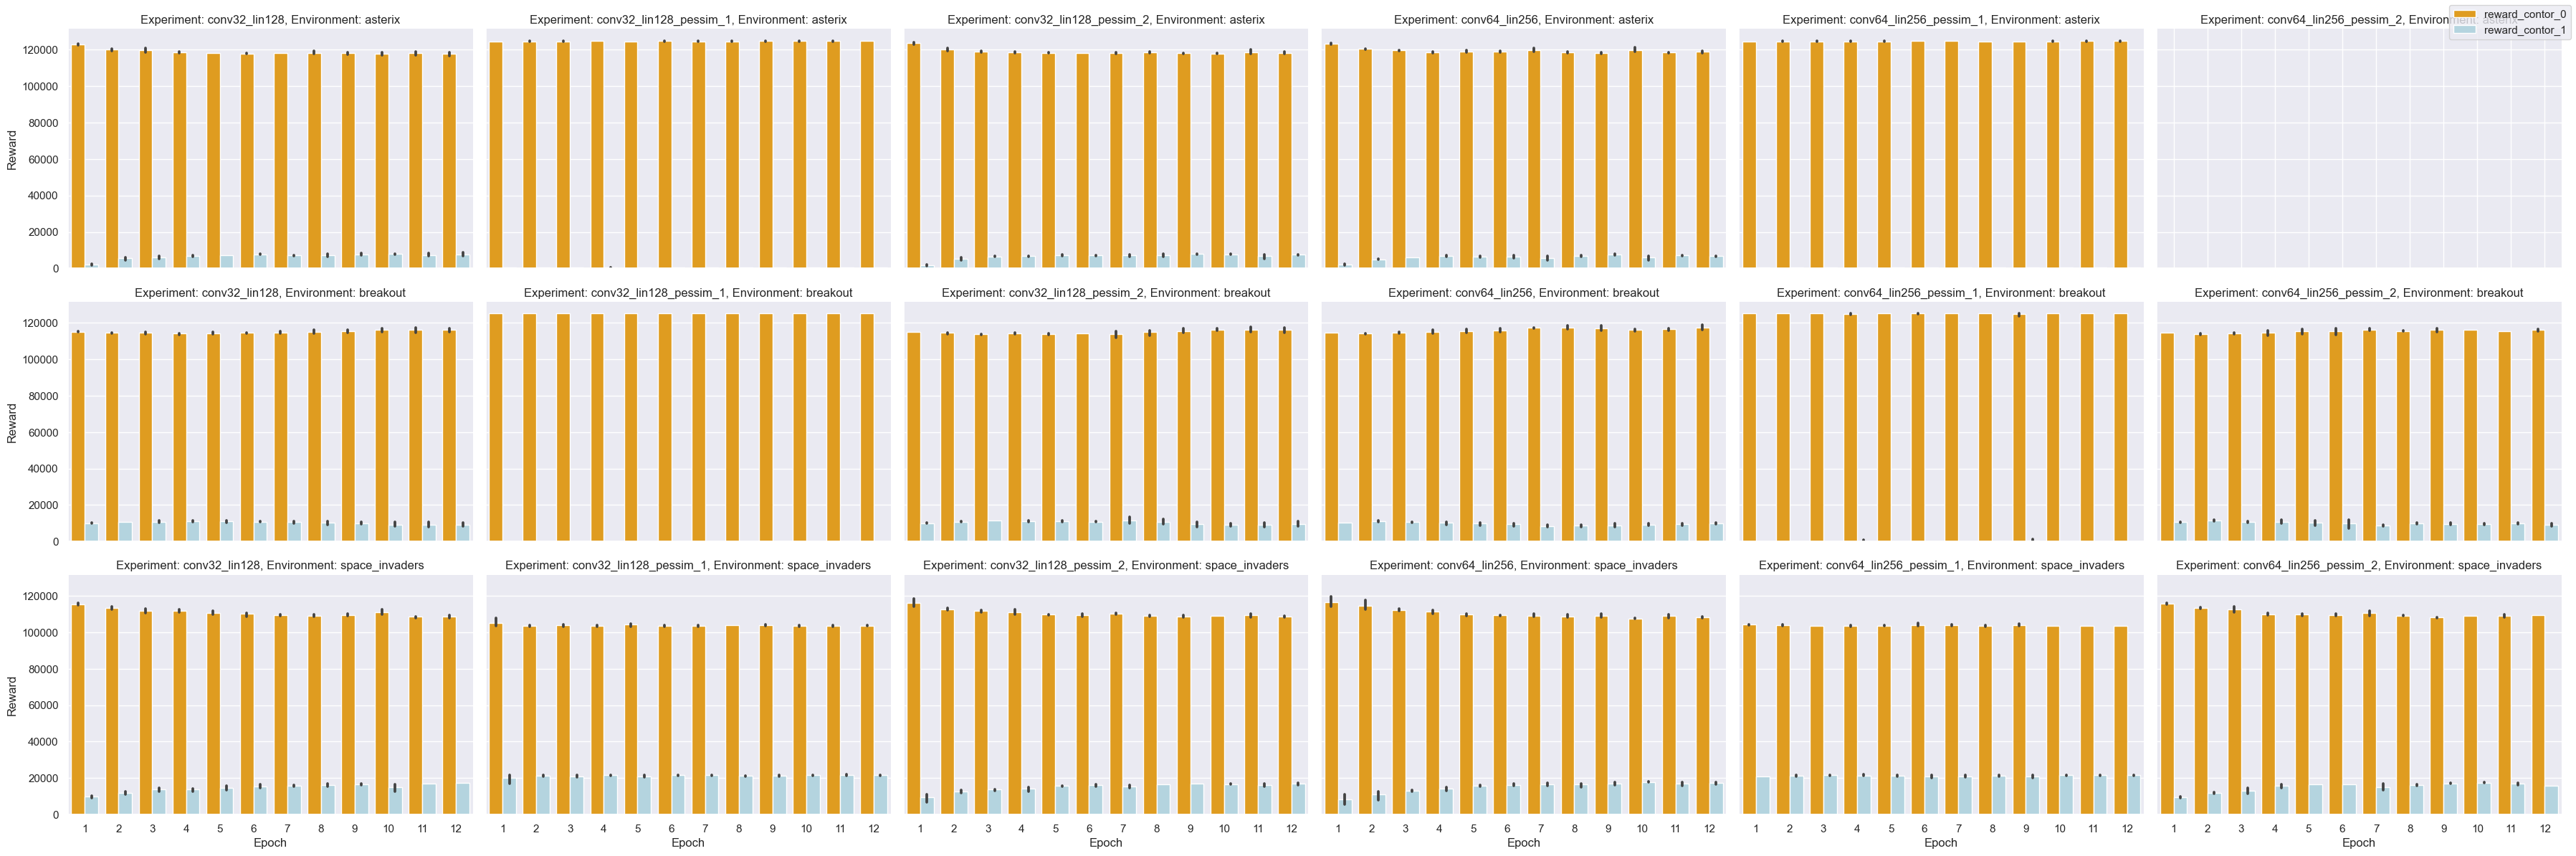

In [11]:
# Assuming your DataFrame is named `df`
df_pivot = df.melt(id_vars=['experiment_name', 'environment', 'epoch'],
                   value_vars=['reward_contor_0', 'reward_contor_1'],
                   var_name='reward_contor', value_name='counts')

g = sns.FacetGrid(df_pivot, row='environment', col='experiment_name', height=4, aspect=1.5)
order = ['reward_contor_0', 'reward_contor_1']
palette = ['orange', 'lightblue']

g.map(sns.barplot, 'epoch', 'counts', 'reward_contor', palette=palette)

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

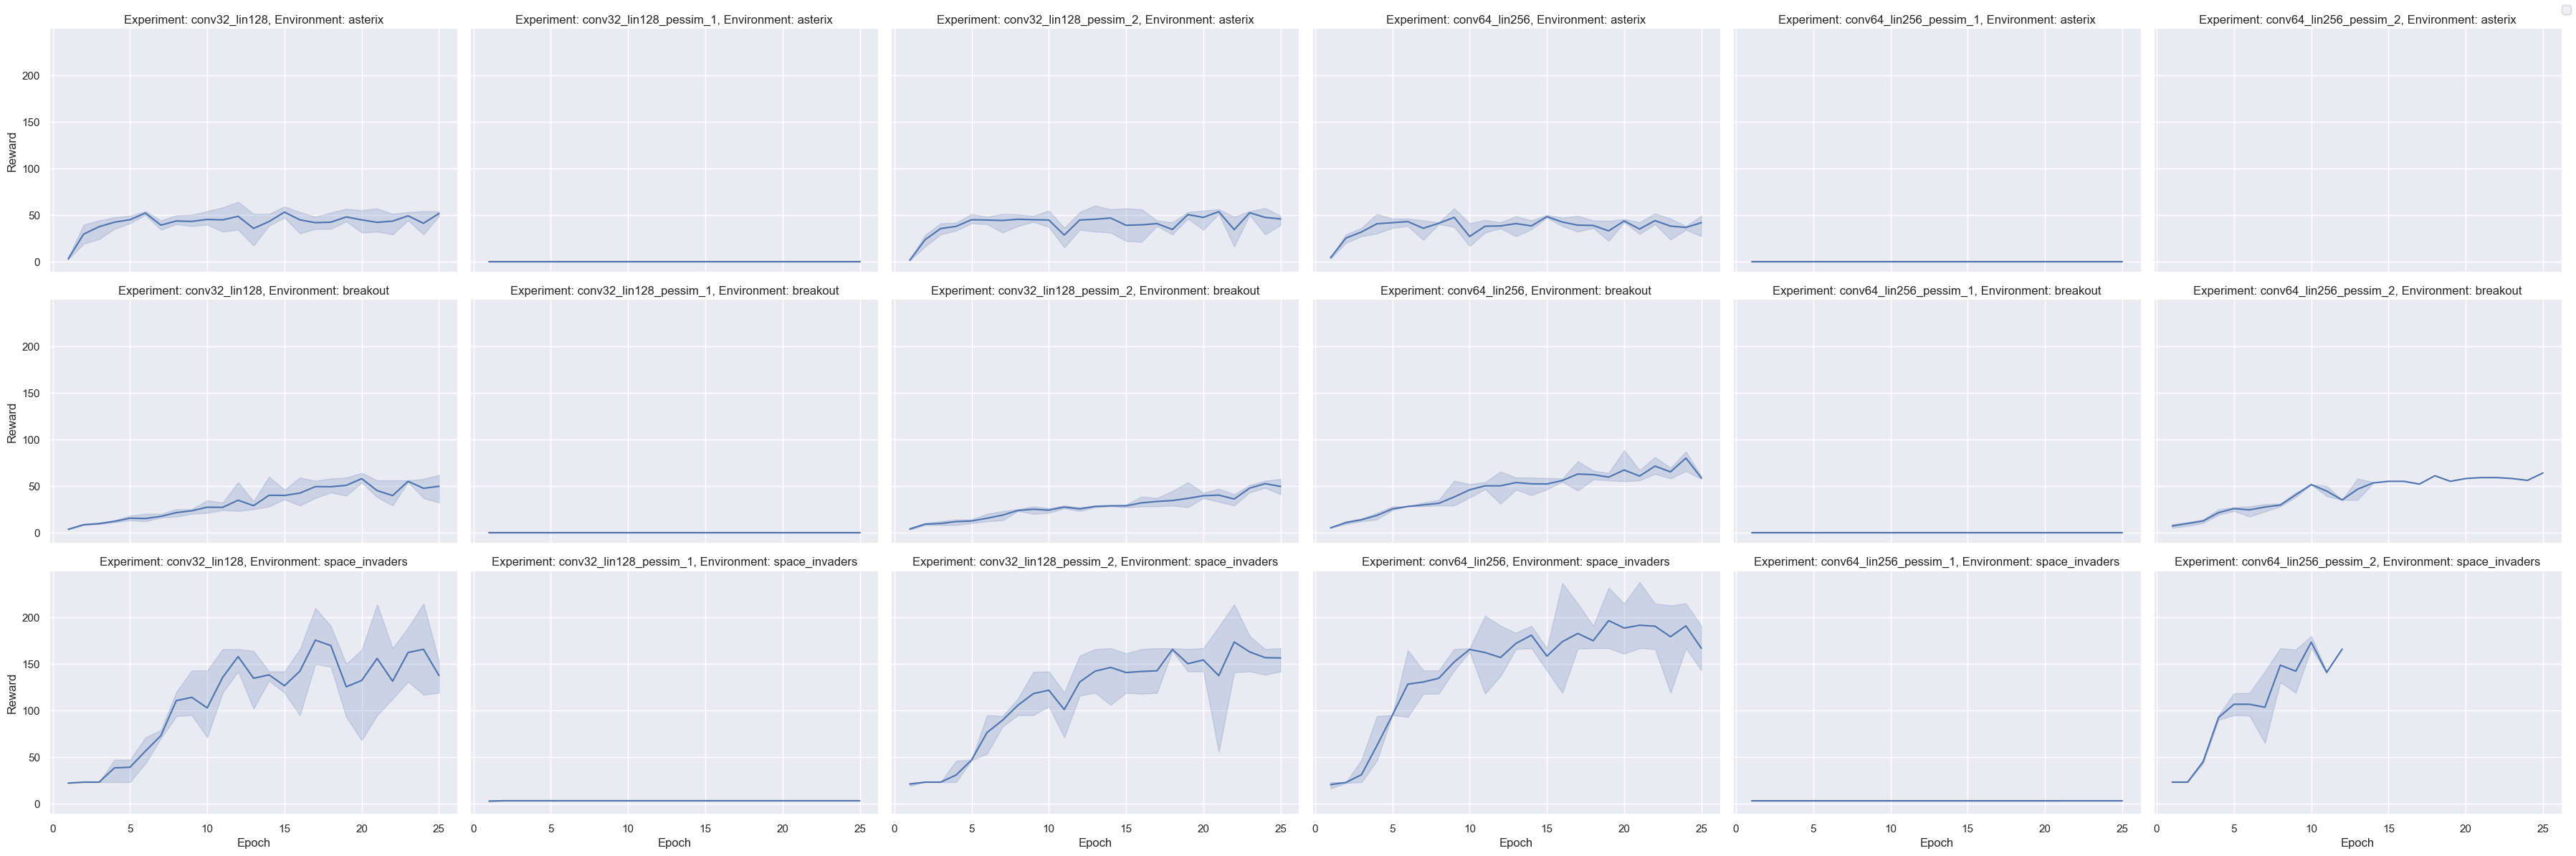

In [12]:
# Assuming your DataFrame is named `df`


g = sns.FacetGrid(df, row='environment', col='experiment_name', height=4, aspect=1.5)

g.map(sns.lineplot, 'epoch', 'episode_rewards_median')

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

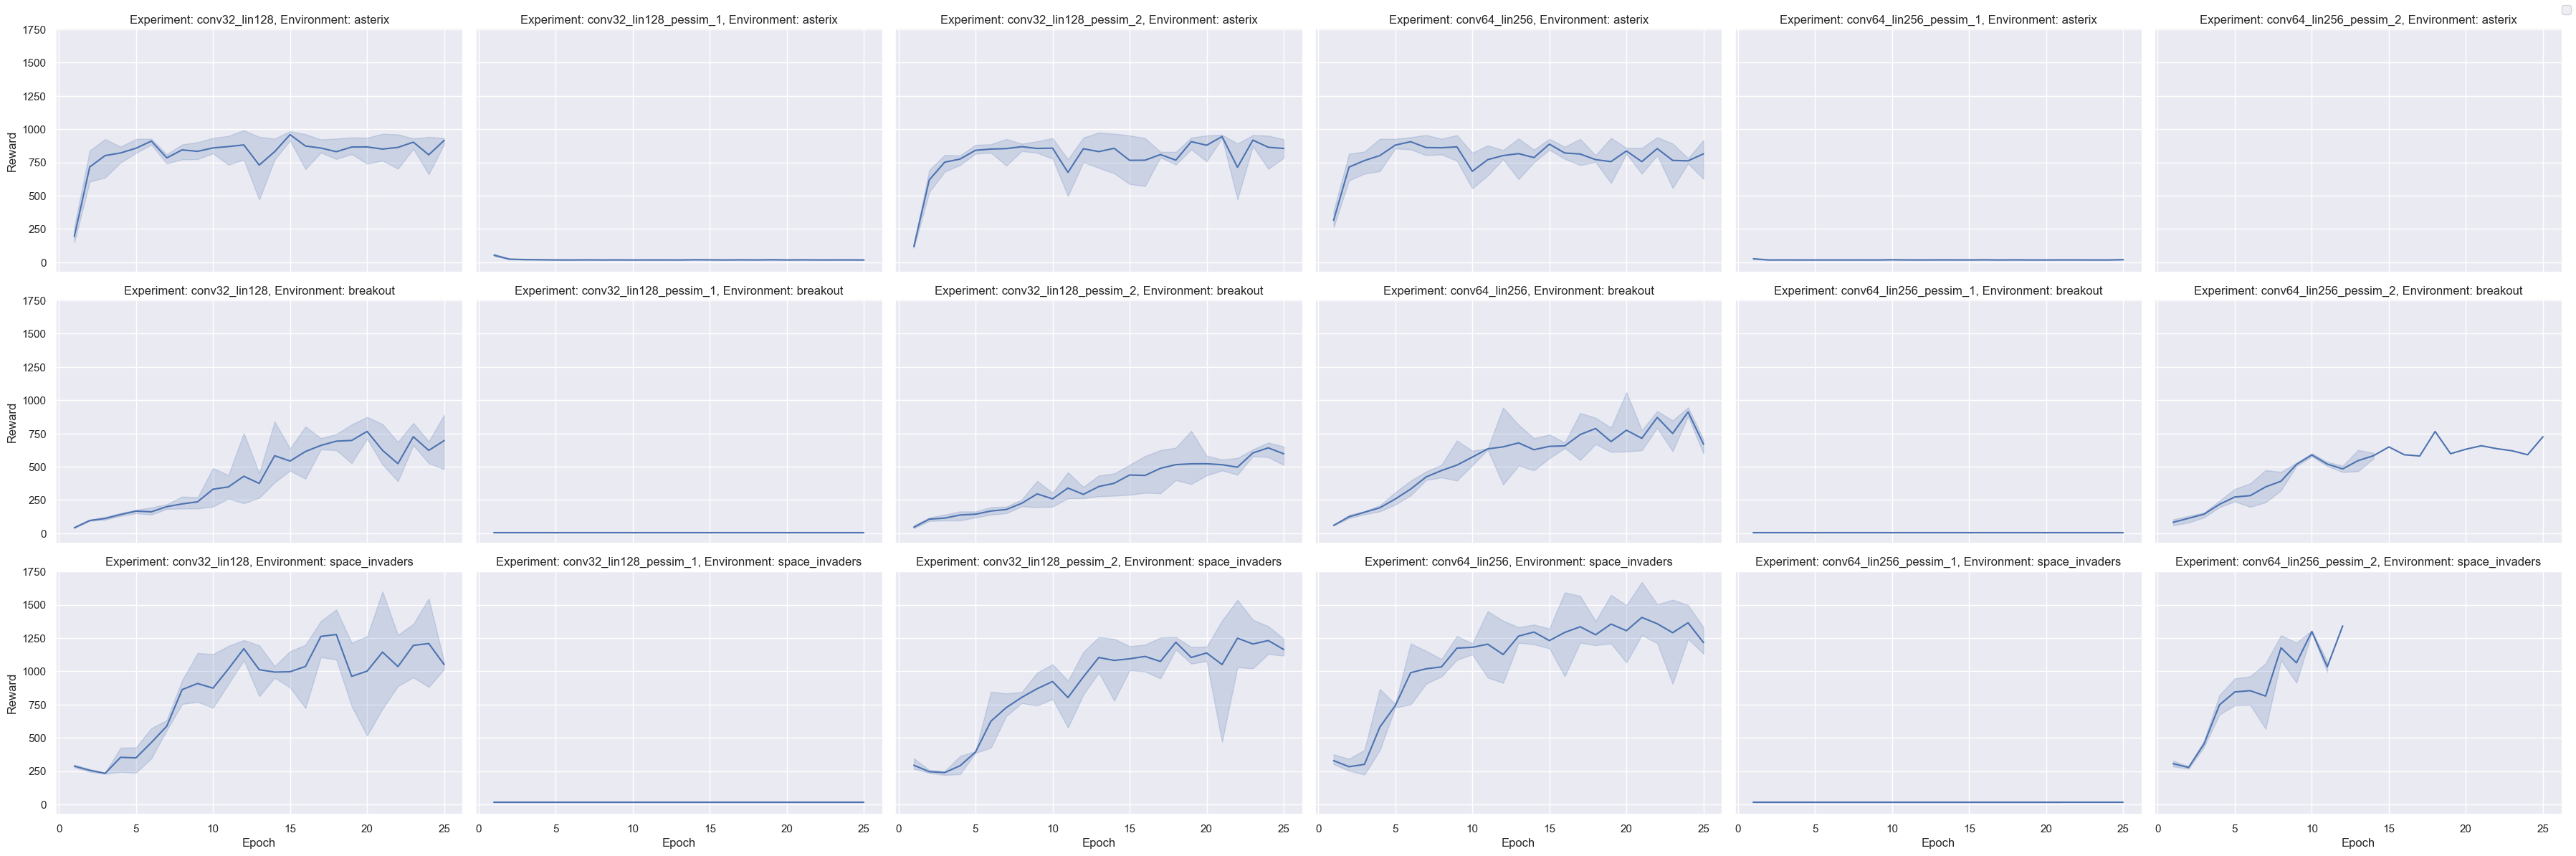

In [13]:
# Assuming your DataFrame is named `df`

g = sns.FacetGrid(df, row='environment', col='experiment_name', height=4, aspect=1.5)

g.map(sns.lineplot, 'epoch', 'episode_frames_median')

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

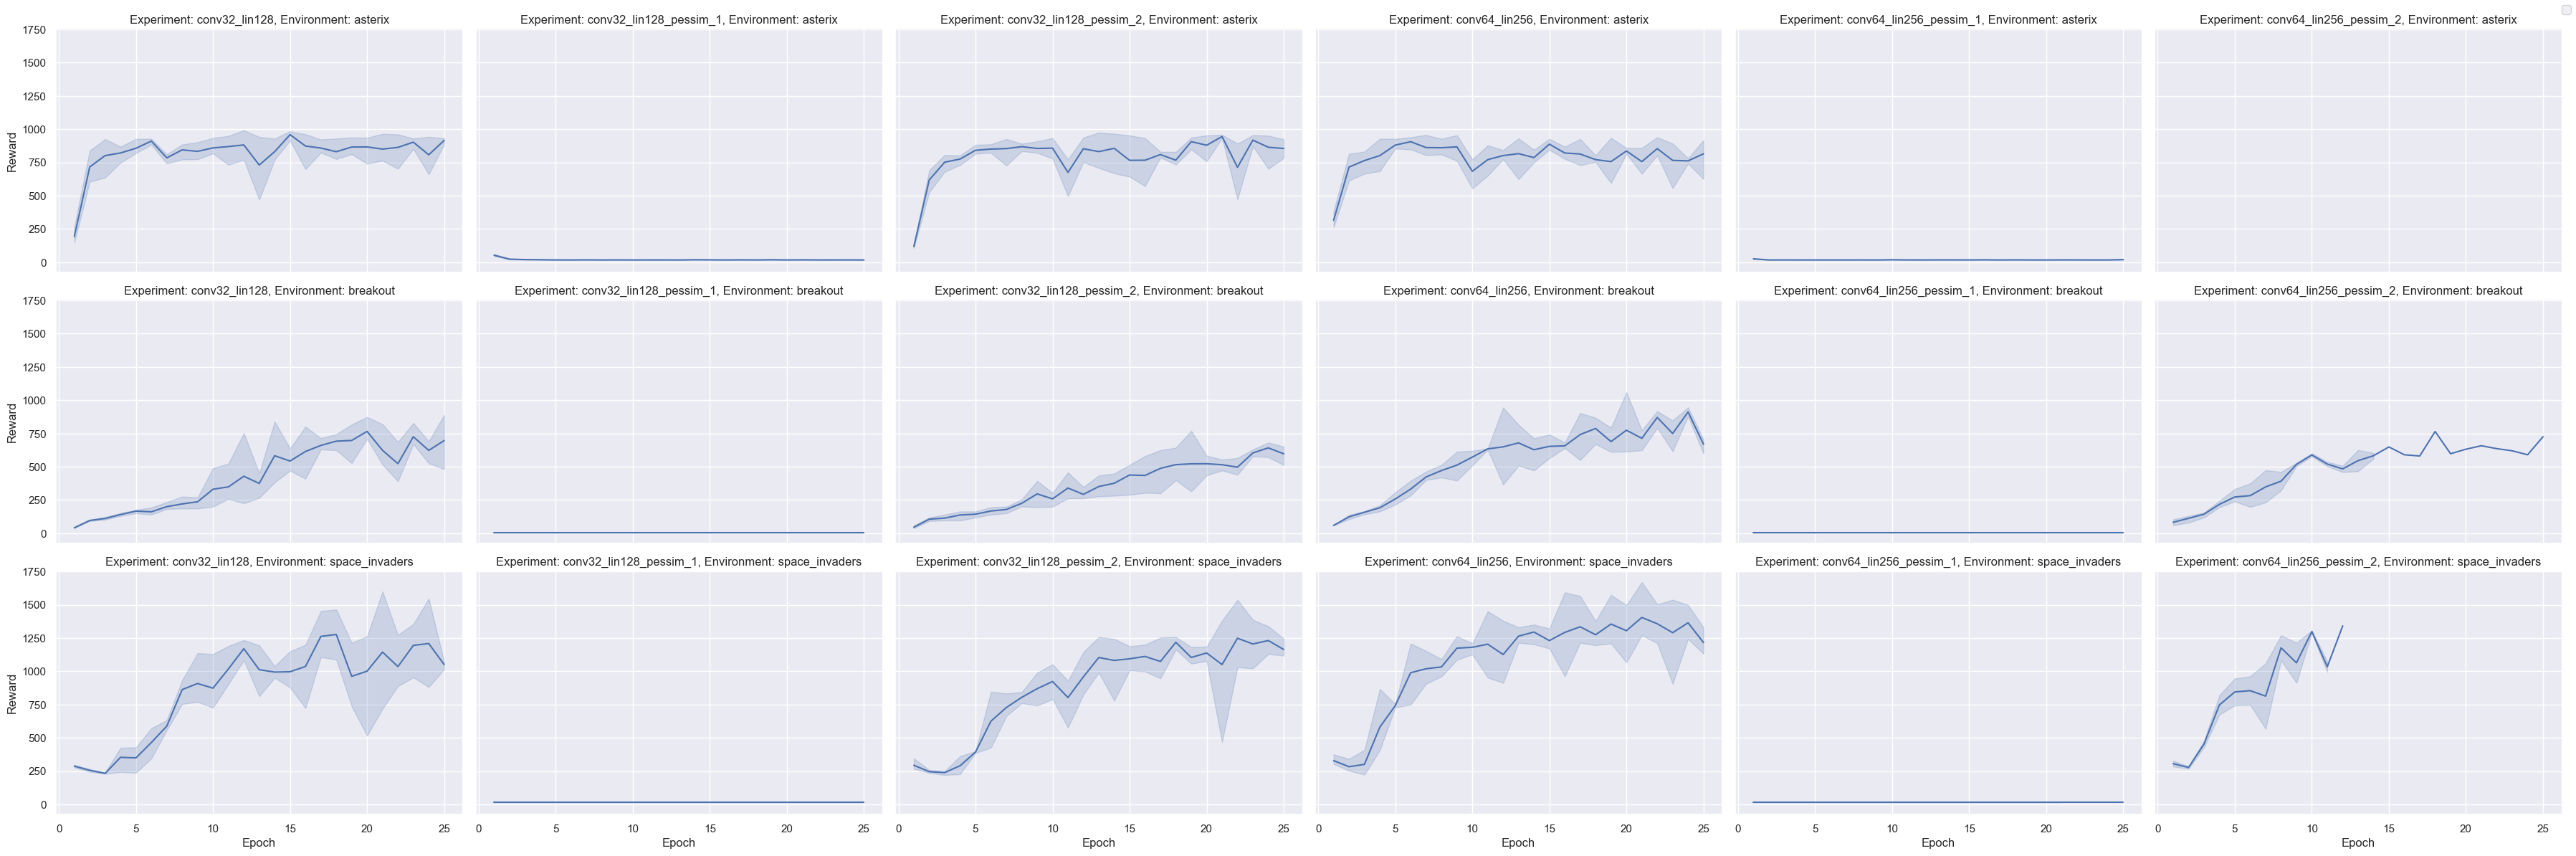

In [14]:
# Assuming your DataFrame is named `df`

g = sns.FacetGrid(df, row='environment', col='experiment_name', height=4, aspect=1.5)

g.map(sns.lineplot, 'epoch', 'episode_frames_median')

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

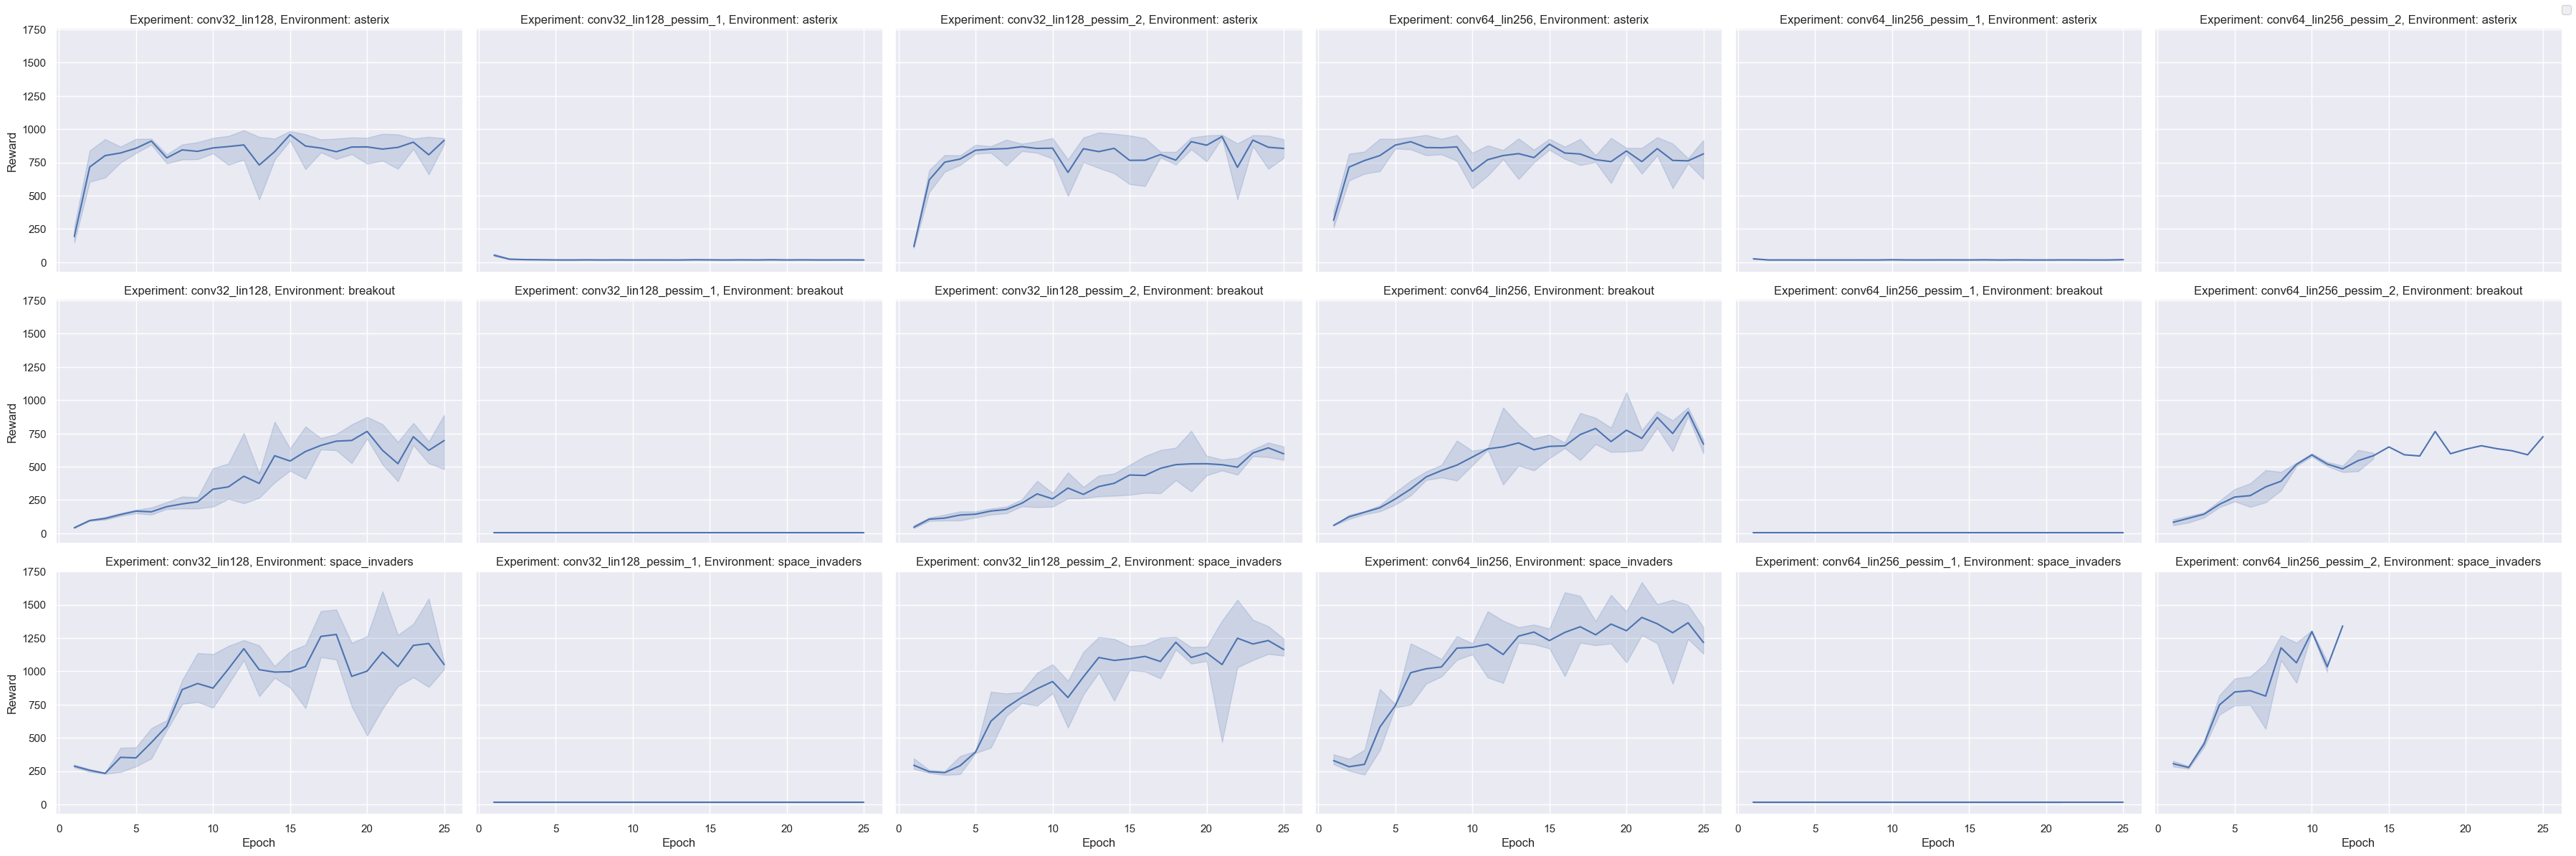

In [15]:
g = sns.FacetGrid(df, row='environment', col='experiment_name', height=4, aspect=1.5)

g.map(sns.lineplot, 'epoch', 'episode_frames_median')

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

In [28]:
from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import apply_redo_parametrization
import scipy
from experiments.experiment_utils import (
    search_files_containing_string,
)

# Collect all paths to models in a specified folder
file_dir = os.path.dirname(os.path.abspath("."))
training_outputs_folder_path = os.path.join(proj_root, "experiments", "training", "outputs")
pruning_outputs_folder_path = os.path.join(file_dir, "outputs")

experiments_folder = os.path.join(training_outputs_folder_path, training_timestamp_folder)

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

for exp in experiment_paths:
    exp["models_folder_path"] = os.path.dirname(exp["model_path"])


def mask_to_score_distance(mask, scores):
    num_ones = np.count_nonzero(mask)

    if num_ones == 0:
        return 0
    
    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)
    
    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True
     
    # Calculate the Hamming distance between the masks
    hamming_distance = torch.sum(torch.logical_and(mask, new_mask))
    hamming_relative_distance = hamming_distance.item() / len(mask)

    return hamming_relative_distance

def mask_vs_norm_stats(mask, scores):
    num_ones = np.count_nonzero(mask)
    
    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)
    
    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True
     
    # Calculate the Hamming distance between the masks
    only_redo = torch.sum(torch.logical_and(mask, torch.eq(new_mask, False))).item() 
    intersect = torch.sum(torch.logical_and(mask, new_mask)).item() 
    only_pruning = torch.sum(torch.logical_and(torch.eq(mask, False), new_mask)).item()

    return only_redo, intersect, only_pruning

def get_rankings(scores):
    sorted_indices = torch.argsort(scores)

    # Initialize tensor for rankings
    rankings = torch.zeros_like(scores, dtype=torch.long)

    # Assign ranks to scores
    rankings[sorted_indices] = torch.arange(1, len(scores) + 1)

    return rankings

def compare_redo_pruning(exp_paths):

    training_stats_data = torch.load(exp_paths["stats_path"])
    redo_scores = training_stats_data["redo_scores"]["policy"]

    checkpoints_paths = search_files_containing_string(
        exp_paths["models_folder_path"], "mck", substring_location="containing"
    )

    # read the config so that the model architecture can be loaded
    with open(exp_paths["config_path"], "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)

    results = []
    for checkpoint_path in checkpoints_paths:
        
        # Build a new model
        validation_env = build_environment(
            cfg["environment"], cfg["seed"]
        )

        # returns state as [w, h, channels]
        state_shape = validation_env.observation_space.shape

        # permute to get batch, channel, w, h shape
        # specific to minatar
        in_features = (state_shape[2], state_shape[0], state_shape[1])
        in_channels = in_features[0]
        num_actions = validation_env.action_space.n

        checkpoint_model = Conv_QNET(in_features = in_features, 
                                    in_channels = in_channels, 
                                    num_actions = num_actions, 
                                    **cfg["estimator"]["args_"])
        checkpoint_model = apply_redo_parametrization(checkpoint_model, tau=0.1)

        # Get the state of the model
        checkpoint_models_state = torch.load(checkpoint_path)
        checkpoint_model.load_state_dict(checkpoint_models_state["policy_model_state_dict"])
        model_state = checkpoint_model.state_dict()

        # Compute kendall rank correlation coefficient for each layer
        layer_weight_keys = ["features.0.weight", "features.2.weight", "fc.0.weight"]
        for i, layer_key in enumerate(layer_weight_keys):
            weights = model_state[layer_key]

            # compute the weight of the neurons in this layer
            if weights.dim() > 2:
                l1_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
            else:
                l1_norms = torch.sum(torch.abs(weights), dim=(1))

            neuron_rankings = get_rankings(l1_norms)
        
            check_index = int(os.path.basename(checkpoint_path).split("_")[1]) - 1 # get the index of the checkpoint
            
            redo_score = redo_scores[check_index][i]
            redo_rankings = get_rankings(torch.tensor(redo_score))

            k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
            s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
            p_corr, p_pval = scipy.stats.pearsonr(l1_norms, redo_score)

            # also do an experiment with thresholding  

            tau_vals = [0.025, 0.1]

            for tau in tau_vals:
                dormant_neurons_mask = (redo_score <= tau)
                
                dormant_neurons_idx = dormant_neurons_mask.nonzero().flatten()

                only_redo, intersect, only_pruning = mask_vs_norm_stats(
                    dormant_neurons_mask, l1_norms
                )

                new_row = {"seed": cfg["seed"],
                        "env": cfg["environment"],
                        "experiment": "_".join(cfg["experiment_name"].split("_")[:2]), # WARNING
                        "experiment_name": cfg["experiment_name"],
                        "tau": tau,
                        "nr_only_redo": only_redo,
                        "nr_intersect": intersect,
                        "nr_only_pruning": only_pruning,
                        "dead_neuron_l1norms": l1_norms[dormant_neurons_idx],
                        "dead_neuron_l1norms_avg": np.average(l1_norms[dormant_neurons_idx]),
                        "dead_neuron_ratio": len(dormant_neurons_idx) / len(redo_score),
                        "redo_l1norm_hamming": mask_to_score_distance(dormant_neurons_mask, l1_norms),
                        "checkpoint": os.path.basename(checkpoint_path),
                        "epoch": check_index, 
                        "layer": layer_key,
                        "kendall_r_corr": k_corr, 
                        "kendall_r_pval": k_pval,
                        "spearman_r_corr": s_corr, 
                        "spearman_r_pval": s_pval,
                        "pearson_corr": p_corr, 
                        "pearson_pval": p_pval
                        }
                results.append(new_row)

    df = pd.DataFrame(results)

    return df 
    

In [29]:
exp_analysis_results = []

for exp_paths in experiment_paths:
    exp_analysis_results.append(compare_redo_pruning(exp_paths))

# concatenate the dataframes vertically
df_res = pd.concat(exp_analysis_results)
df_res

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment MinAtar/Asterix-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
C:\Users\Chainsword\AppData\Local\Temp\ipykernel_2060\3730378681.py:127: 

,seed,env,experiment,experiment_name,tau,nr_only_redo,nr_intersect,nr_only_pruning,dead_neuron_l1norms,dead_neuron_l1norms_avg,...,redo_l1norm_hamming,checkpoint,epoch,layer,kendall_r_corr,kendall_r_pval,spearman_r_corr,spearman_r_pval,pearson_corr,pearson_pval
0,0,asterix,conv32_lin128,conv32_lin128,0.025,9,7,9,"[tensor(3.2236), tensor(3.5238), tensor(4.0699...",3.631896,...,0.218750,mck_1,0,features.0.weight,0.024194,8.595930e-01,0.074413,6.856535e-01,0.163163,3.722483e-01
1,0,asterix,conv32_lin128,conv32_lin128,0.100,0,32,0,"[tensor(3.2236), tensor(3.5238), tensor(3.7540...",3.643417,...,1.000000,mck_1,0,features.0.weight,0.024194,8.595930e-01,0.074413,6.856535e-01,0.163163,3.722483e-01
2,0,asterix,conv32_lin128,conv32_lin128,0.025,9,10,9,"[tensor(11.1663), tensor(10.8332), tensor(10.7...",11.582295,...,0.312500,mck_1,0,features.2.weight,-0.120968,3.415331e-01,-0.159824,3.822452e-01,0.018944,9.180340e-01
3,0,asterix,conv32_lin128,conv32_lin128,0.100,1,30,1,"[tensor(11.1663), tensor(11.0635), tensor(10.8...",11.459133,...,0.937500,mck_1,0,features.2.weight,-0.120968,3.415331e-01,-0.159824,3.822452e-01,0.018944,9.180340e-01
4,0,asterix,conv32_lin128,conv32_lin128,0.025,1,117,1,"[tensor(23.9743), tensor(20.9501), tensor(18.5...",19.844744,...,0.914062,mck_1,0,fc.0.weight,0.707677,2.216119e-32,0.861455,6.845524e-39,0.921949,9.573426e-54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2,space_invaders,conv64_lin256,conv64_lin256_pessim_2,0.100,0,64,0,"[tensor(5.6099), tensor(6.3231), tensor(5.7544...",5.462002,...,1.000000,mck_9,8,features.0.weight,0.268849,1.688653e-03,0.385806,1.641246e-03,0.202971,1.077129e-01
62,2,space_invaders,conv64_lin256,conv64_lin256_pessim_2,0.025,8,45,8,"[tensor(22.7592), tensor(29.4349), tensor(24.3...",29.520233,...,0.703125,mck_9,8,features.2.weight,0.054563,5.239305e-01,0.052839,6.783841e-01,0.045745,7.196458e-01
63,2,space_invaders,conv64_lin256,conv64_lin256_pessim_2,0.100,0,64,0,"[tensor(22.7592), tensor(29.4349), tensor(24.3...",29.602055,...,1.000000,mck_9,8,features.2.weight,0.054563,5.239305e-01,0.052839,6.783841e-01,0.045745,7.196458e-01
64,2,space_invaders,conv64_lin256,conv64_lin256_pessim_2,0.025,8,240,8,"[tensor(80.6034), tensor(88.1373), tensor(93.4...",71.988098,...,0.937500,mck_9,8,fc.0.weight,0.214216,3.286097e-07,0.335630,3.706516e-08,0.134286,3.172917e-02


In [30]:
df_res.columns

Index(['seed', 'env', 'experiment', 'experiment_name', 'tau', 'nr_only_redo',
       'nr_intersect', 'nr_only_pruning', 'dead_neuron_l1norms',
       'dead_neuron_l1norms_avg', 'dead_neuron_ratio', 'redo_l1norm_hamming',
       'checkpoint', 'epoch', 'layer', 'kendall_r_corr', 'kendall_r_pval',
       'spearman_r_corr', 'spearman_r_pval', 'pearson_corr', 'pearson_pval'],
      dtype='object')

In [31]:
df_res["experiment_name"].unique()

array(['conv32_lin128', 'conv32_lin128_pessim_1',
       'conv32_lin128_pessim_2', 'conv64_lin256',
       'conv64_lin256_pessim_1', 'conv64_lin256_pessim_2'], dtype=object)

In [36]:

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

df_sub1 = df_res[df_res["experiment_name"].isin(['conv32_lin128', 'conv32_lin128_pessim_1',
       'conv32_lin128_pessim_2'])]

experiment_order = ['conv32_lin128', 'conv32_lin128_pessim_1',
       'conv32_lin128_pessim_2']

for layer in df_sub1["layer"].unique():
    sub_df = df_sub1[(df_sub1["tau"] == 0.025) & (df_sub1["layer"] == layer)]

    melted_df = sub_df.melt(id_vars=['env', 'experiment_name', 'epoch'],
                            value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                            var_name='Category', value_name='Value')

    fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment_name",
                category_orders={"experiment_name": experiment_order}, 
                height=600)
    
    title = f"Redo and Norm overlap - Layer {layer} shared Y"
    file_path = f"imgs/{title}.png"

    # Save the figure as a PNG image
    # pio.write_image(fig, file_path)

    fig.update_layout(title=title)
    fig.show()


    melted_df = sub_df.melt(id_vars=['env', 'experiment_name', 'epoch'],
                            value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                            var_name='Category', value_name='Value')

    fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment_name",
                category_orders={"experiment_name": experiment_order}, height=600)

    fig.update_yaxes(matches=None, showticklabels=True)

    title = f"Redo and Norm overlap - Layer {layer}"
    file_path = f"imgs/{title}.png"
    
    # Save the figure as a PNG image
    # pio.write_image(fig, file_path)

    fig.update_layout(title=title)

    fig.show()

In [37]:

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

df_sub1 = df_res[df_res["experiment_name"].isin(['conv64_lin256',
       'conv64_lin256_pessim_1', 'conv64_lin256_pessim_2'])]

experiment_order = ['conv64_lin256',
       'conv64_lin256_pessim_1', 'conv64_lin256_pessim_2']

for layer in df_sub1["layer"].unique():
    sub_df = df_sub1[(df_sub1["tau"] == 0.025) & (df_sub1["layer"] == layer)]

    melted_df = sub_df.melt(id_vars=['env', 'experiment_name', 'epoch'],
                            value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                            var_name='Category', value_name='Value')

    fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment_name",
                category_orders={"experiment_name": experiment_order}, 
                height=600)
    
    title = f"Redo and Norm overlap - Layer {layer} shared Y"
    file_path = f"imgs/{title}.png"

    # Save the figure as a PNG image
    # pio.write_image(fig, file_path)

    fig.update_layout(title=title)
    fig.show()


    melted_df = sub_df.melt(id_vars=['env', 'experiment_name', 'epoch'],
                            value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                            var_name='Category', value_name='Value')

    fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment_name",
                category_orders={"experiment_name": experiment_order}, height=600)

    fig.update_yaxes(matches=None, showticklabels=True)

    title = f"Redo and Norm overlap - Layer {layer}"
    file_path = f"imgs/{title}.png"
    
    # Save the figure as a PNG image
    # pio.write_image(fig, file_path)

    fig.update_layout(title=title)

    fig.show()

In [ ]:
# training_outputs_folder_path = (
#     r"D:\Work\PhD\minatar_work\experiments\training\outputs"
# )
# training_timestamp_folder = "2023_07_13-03_01_30"

# experiment_paths = collect_training_output_files(
#         os.path.join(training_outputs_folder_path, training_timestamp_folder)
#     )

# experiment_paths[0]

{'model_path': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\model_checkpoints\\mck_2',
 'training_folder_path': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0',
 'config_path': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\conv32_lin128_pessim_1_space_invaders_0_config',
 'stats_path': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\conv32_lin128_pessim_1_space_invaders_0_train_stats'}

In [ ]:
sys.path.append(os.path.dirname(os.path.dirname(".")))

from minatar_dqn.my_dqn import AgentDQN, build_environment
from minatar_dqn.utils.my_logging import setup_logger


exp_files = experiment_paths[0]
with open(exp_files["config_path"], "r") as f:
    config = yaml.safe_load(f)

logger = setup_logger(
            env_name=config["environment"]
        )

### Setup environments ###
train_env = build_environment(
    game_name=config["environment"], random_seed=config["seed"]
)
validation_env = build_environment(
    game_name=config["environment"], random_seed=config["seed"]
)
    
my_agent = AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=exp_files["training_folder_path"],
    experiment_name=config["full_experiment_name"],
    resume_training_path=exp_files["training_folder_path"],
    logger=logger,
    config = config)


2023-07-13 03:11:15,814 - root - INFO - Setup reward mapping.
2023-07-13 03:11:15,815 - root - INFO - Loaded configuration settings.
2023-07-13 03:11:15,818 - root - INFO - Initialized newtworks and optimizer.
2023-07-13 03:11:15,818 - root - INFO - Applied redo parametrization to policy model.
2023-07-13 03:11:15,819 - root - INFO - Applied redo parametrization to target model.
2023-07-13 03:11:18,711 - root - INFO - Loaded previous training status from the following files: {'replay_buffer_file': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\conv32_lin128_pessim_1_space_invaders_0_replay_buffer', 'train_stats_file': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\conv32_lin128_pessim_1_space_invaders_0_train_stats', 'checkpoint_model_file': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_

In [ ]:
res = my_agent.replay_buffer.sample(4)
res[3]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
          [0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
          [0., 1., 1., 1., 0., 1., 1., 0., 0., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         

In [ ]:
config

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 100,
   'train_step_cnt': 20000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 12500}},
 'environment': 'asterix',
 'epochs_to_train': 1,
 'estimator': {'args_': {'conv_hidden_out_size': 32,
   'lin_hidden_out_size': 128},
  'model': 'Conv_QNET'},
 'experiment_name': 'conv32_lin128_pessim_1',
 'experiment_output_folder': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_12-23_14_00\\conv32_lin128_pessim_1\\asterix\\0',
 'experiment_start_timestamp': '2023_07_12-23_14_00',
 'full_experiment_name': 'conv32_lin128_pessim_1_asterix_0',
 'optim': {'args_': {'eps': 0.00015, 'lr': 6.25e-05}, 'name': 'Adam'},
 'path_experiments_outputs': 'd:\\Work\\PhD\\minatar_work\\experiments

In [ ]:
file_dir = os.path.dirname(os.path.abspath(r"D:\Work\PhD\minatar_work\experiments\training\training.py"))

sys.path.append(file_dir)

from training import get_config_paths, read_config_files, generate_run_configs

path_experiments_configs = os.path.join(file_dir, "training_configs")
path_experiments_outputs = os.path.join(file_dir, "outputs")

default_config_path, experiment_config_paths = get_config_paths(
        path_experiments_configs
    )
  
experiment_configs = read_config_files(default_config_path, experiment_config_paths)

runs_configs = generate_run_configs(experiment_configs, path_experiments_outputs)

In [ ]:
from minatar_dqn.my_dqn import RewardPerception

rp = RewardPerception({0: -1, 1: 0})


In [ ]:
rp.percieve_reward(0.0)

-1